In [1]:
import xarray as xr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy
import datetime 

import metpy.calc as mpc
from metpy.units import units

import warnings
warnings.filterwarnings('ignore')


In [2]:

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds



In [3]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [4]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ_abs(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(np.abs(dvardz[iT,iLevs])==np.nanmax(np.abs(dvardz[iT,iLevs])))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

## Read in data (we only really need 2015 for quick test)

In [5]:
## Read in files 

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'

dataDir10   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HTGtimes10/'
caseName_10 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc10htg_useTheta_'


dataDir0p5   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HTGtimes0p5/'
caseName_0p5 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc0p5htg_useTheta_'


dataDir0   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HTGtimes0/'
caseName_0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc0p0htg_useTheta_'
# dataDir0   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HTGtimes0_v2/'
# caseName_0 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc0p0htg_useTheta_'


yearStrings  = np.asarray(['2015'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc',
                            '-07-05-60585.nc',
                            '-07-14-32985.nc',
                            '-07-23-05385.nc',
                            '-07-31-64185.nc',
                            '-08-09-36585.nc',
                            '-08-18-08985.nc',
                            '-08-26-67785.nc' ])

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG   = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h1.'+yearStrings[iYr]
    fileStart_atm_HTG   = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h1.'+yearStrings[iYr]
#     fileStart_atm_HTG10 = dataDir10+caseName_10+yearStrings[iYr]+'jja.cam.h1.'+yearStrings[iYr]
#     fileStart_atm_0p5   = dataDir0p5+caseName_0p5+yearStrings[iYr]+'jja.cam.h1.'+yearStrings[iYr]
    fileStart_atm_HTG10 = dataDir10+caseName_10+yearStrings[iYr]+'jja_try2.cam.h1.'+yearStrings[iYr]
    fileStart_atm_0p5   = dataDir0p5+caseName_0p5+yearStrings[iYr]+'jja_try2.cam.h1.'+yearStrings[iYr]
#     fileStart_atm_0   = dataDir0+caseName_0+yearStrings[iYr]+'jja.cam.h1.'+yearStrings[iYr]       # First attempt...
#     fileStart_atm_0     = dataDir0+caseName_0+yearStrings[iYr]+'jja_v2.cam.h1.'+yearStrings[iYr]  # Move where multiplier happens (same as above result)
    fileStart_atm_0     = dataDir0+caseName_0+yearStrings[iYr]+'jja_try2.cam.h1.'+yearStrings[iYr]  # Change the src.cam mods, which fixed the HMG case before...


    for iFile in range(len(dateEndFiles)):

        fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]
        fileName_atm_HTG = fileStart_atm_HTG+dateEndFiles[iFile]
        fileName_atm_10  = fileStart_atm_HTG10+dateEndFiles[iFile]
        fileName_atm_0p5 = fileStart_atm_0p5+dateEndFiles[iFile]
        fileName_atm_0   = fileStart_atm_0+dateEndFiles[iFile]
        
        with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
            HMG_camDS = cesm_correct_time(HMG_camDS)
            HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
            HTG_camDS = cesm_correct_time(HTG_camDS)
            HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex() 
        with xr.open_dataset(fileName_atm_10, decode_times=False) as HTG10_camDS:
            HTG10_camDS = cesm_correct_time(HTG10_camDS)
            HTG10_camDS['time'] = HTG10_camDS.indexes['time'].to_datetimeindex() 
        with xr.open_dataset(fileName_atm_0p5, decode_times=False) as HTGp5_camDS:
            HTGp5_camDS = cesm_correct_time(HTGp5_camDS)
            HTGp5_camDS['time'] = HTGp5_camDS.indexes['time'].to_datetimeindex() 
        with xr.open_dataset(fileName_atm_0, decode_times=False) as HTG0_camDS:
            HTG0_camDS = cesm_correct_time(HTG0_camDS)
            HTG0_camDS['time'] = HTG0_camDS.indexes['time'].to_datetimeindex() 
            

        # Discard the first two days if iFile == 0  
        if iFile==0:
            iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
            timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

            HTG0_camDS     = HTG0_camDS.isel(time=timeArr)
            HTGp5_camDS    = HTGp5_camDS.isel(time=timeArr)
            HTG10_camDS    = HTG10_camDS.isel(time=timeArr)
            HTG_camDS      = HTG_camDS.isel(time=timeArr)
            HMG_camDS      = HMG_camDS.isel(time=timeArr)


        if fileCount==0:
            HTG0camDS_all  = HTG0_camDS
            HTGp5camDS_all = HTGp5_camDS
            HTGcamDS_all   = HTG_camDS
            HTG10camDS_all = HTG10_camDS
            HMGcamDS_all   = HMG_camDS
            
            
        else: 
            HTG0camDS_all  = xr.concat([HTG0camDS_all,HTG0_camDS], dim='time')
            HTGp5camDS_all = xr.concat([HTGp5camDS_all,HTGp5_camDS], dim='time')
            HTG10camDS_all = xr.concat([HTG10camDS_all,HTG10_camDS], dim='time')
            HTGcamDS_all   = xr.concat([HTGcamDS_all,HTG_camDS], dim='time')
            HMGcamDS_all   = xr.concat([HMGcamDS_all,HMG_camDS], dim='time')

        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))


Done with file 1 of 11 
Done with file 2 of 11 
Done with file 3 of 11 
Done with file 4 of 11 
Done with file 5 of 11 
Done with file 6 of 11 
Done with file 7 of 11 
Done with file 8 of 11 
Done with file 9 of 11 
Done with file 10 of 11 
Done with file 11 of 11 


(0.0, 1.0)

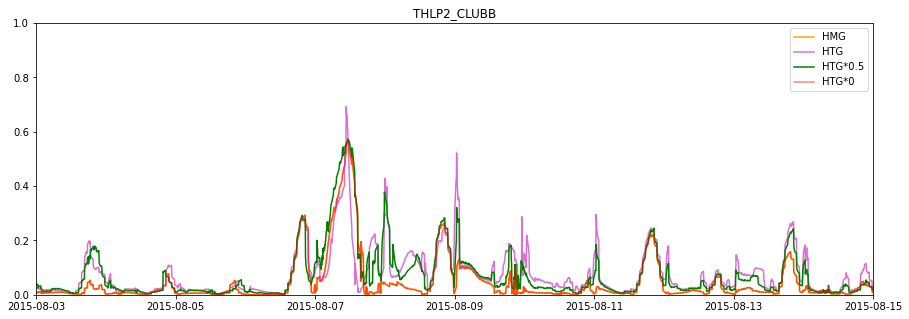

In [21]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'THLP2_CLUBB'
levSel     = -1


axs.plot(HMGcamDS_all.time.values,    np.squeeze(HMGcamDS_all[varSelPlot].values[:,levSel]), color='orange', label='HMG')
# axs.plot(HMGv2camDS_all.time.values,  np.squeeze(HMGv2camDS_all[varSelPlot].values[:,levSel]), color='red', label='HMG_v2')
# axs.plot(HMGcamDSrepeat_all.time.values,  np.squeeze(HMGcamDSrepeat_all[varSelPlot].values[:,levSel]), color='olive', label='HMGrepeat')

axs.plot(HTGcamDS_all.time.values,    np.squeeze(HTGcamDS_all[varSelPlot].values[:,levSel]), color='orchid', label='HTG')
# axs.plot(HTG10camDS_all.time.values,  np.squeeze(HTG10camDS_all[varSelPlot].values[:,levSel]), color='purple', label='HTG*10')
axs.plot(HTGp5camDS_all.time.values,  np.squeeze(HTGp5camDS_all[varSelPlot].values[:,levSel]), color='green', label='HTG*0.5')
axs.plot(HTG0camDS_all.time.values,   np.squeeze(HTG0camDS_all[varSelPlot].values[:,levSel]), color='red',alpha=0.5, label='HTG*0')

axs.set_xlim([datetime.date(2015,8,3), datetime.date(2015,8,15)])
axs.legend()
axs.set_title(varSelPlot)

axs.set_ylim([0,1])


ValueError: operands could not be broadcast together with shapes (25056,1,1) (16347,1,1) 

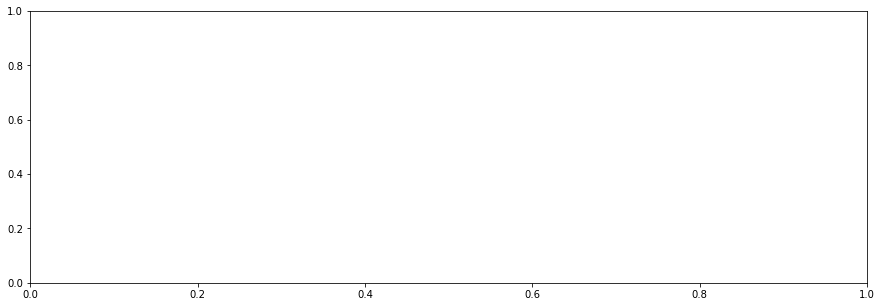

In [15]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'RTPTHLP_CLUBB'
levSel     = -1


# axs.plot(HMGcamDS_all.time.values,    np.squeeze(HMGcamDS_all[varSelPlot].values[:,levSel]), color='orange', label='HMG')
# axs.plot(HTGcamDS_all.time.values,    np.squeeze(HTGcamDS_all[varSelPlot].values[:,levSel]-HMGcamDS_all[varSelPlot].values[:,levSel]), color='orchid', label='HTG')
# axs.plot(HTGp5camDS_all.time.values,  np.squeeze(HTGp5camDS_all[varSelPlot].values[:,levSel]-HMGcamDS_all[varSelPlot].values[:,levSel]), color='blue', label='HTG*0.5')
axs.plot(HTG0camDS_all.time.values,   np.squeeze(HTG0camDS_all[varSelPlot].values[:,levSel]-HMGcamDS_all[varSelPlot].values[:,levSel]), color='green',alpha=0.5, label='HTG*0')

# axs.set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,12)])
axs.legend()
axs.set_title('Surface '+varSelPlot+' Difference (HTG*?-HMG)')

axs.set_ylim([-0.5,0.5])


(-0.5, 0.5)

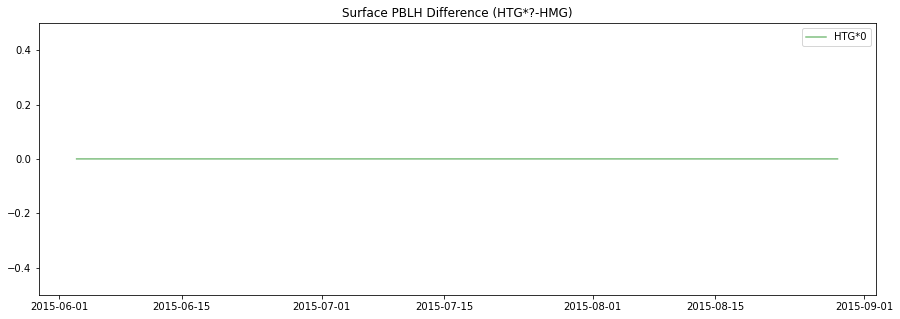

In [9]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PBLH'
levSel     = None


axs.plot(HMGcamDS_all.time.values,    np.squeeze(HMGcamDS_all[varSelPlot].values[:,levSel]), color='orange', label='HMG')
axs.plot(HTGcamDS_all.time.values,    np.squeeze(HTGcamDS_all[varSelPlot].values[:,levSel]-HMGcamDS_all[varSelPlot].values[:,levSel]), color='orchid', label='HTG')
axs.plot(HTGp5camDS_all.time.values,  np.squeeze(HTGp5camDS_all[varSelPlot].values[:,levSel]-HMGcamDS_all[varSelPlot].values[:,levSel]), color='blue', label='HTG*0.5')
axs.plot(HTG0camDS_all.time.values,   np.squeeze(HTG0camDS_all[varSelPlot].values[:,levSel]-HMGcamDS_all[varSelPlot].values[:,levSel]), color='green',alpha=0.5, label='HTG*0')

# axs.set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,12)])
axs.legend()
axs.set_title('Surface '+varSelPlot+' Difference (HTG*?-HMG)')

axs.set_ylim([-0.5,0.5])


Text(0.5, 1.0, 'PBLH')

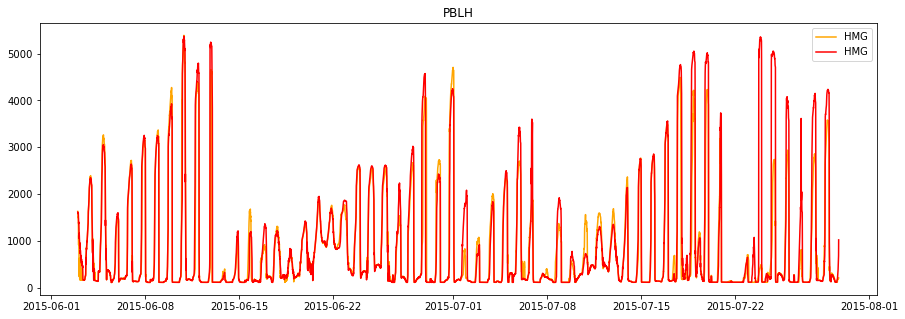

In [10]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

varSelPlot = 'PBLH'
levSel     = None


axs.plot(HMGcamDS_all.time.values,    np.squeeze(HMGcamDS_all[varSelPlot].values[:,levSel]), color='orange', label='HMG')
axs.plot(HMGv2camDS_all.time.values,  np.squeeze(HMGv2camDS_all[varSelPlot].values[:,levSel]), color='red', label='HMG')

# axs.plot(HTGcamDS_all.time.values,    np.squeeze(HTGcamDS_all[varSelPlot].values[:,levSel]), color='orchid', label='HTG')
# axs.plot(HTGp5camDS_all.time.values,  np.squeeze(HTGp5camDS_all[varSelPlot].values[:,levSel]), color='blue', label='HTG*0.5')
# axs.plot(HTG0camDS_all.time.values,   np.squeeze(HTG0camDS_all[varSelPlot].values[:,levSel]), color='green',alpha=0.5, label='HTG*0')

# axs.set_xlim([datetime.date(2015,8,3), datetime.date(2015,8,14)])
axs.legend()
axs.set_title(varSelPlot)

# axs.set_ylim([0,0.5])


Text(0.5, 1.0, 'PBLH (Difference)')

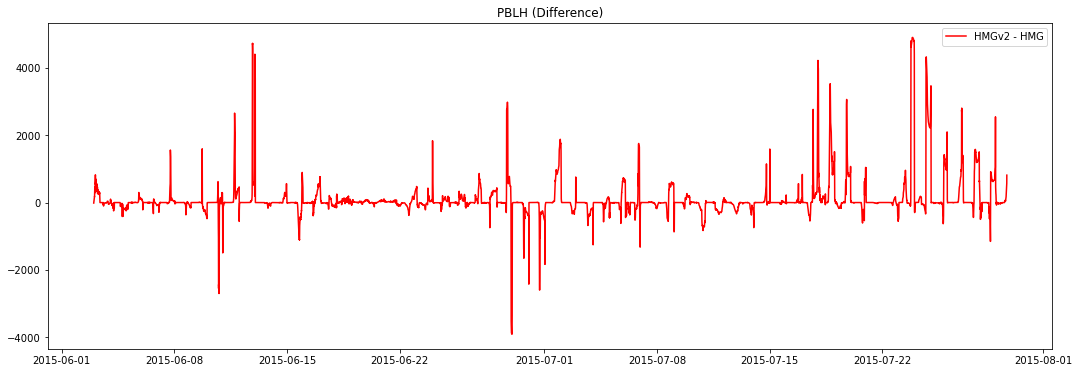

In [12]:
varSelPlot = 'PBLH'
levSel     = None
diffVarSel = HMGv2camDS_all[varSelPlot].values[:,levSel] - HMGcamDS_all[varSelPlot].values[:,levSel]

fig,axs = plt.subplots(1,1, figsize=(18,6))

axs.plot(HMGcamDS_all.time.values,    np.squeeze(diffVarSel), color='red', label='HMGv2 - HMG')

axs.legend()
axs.set_title(varSelPlot+' (Difference)')
# axs.set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,16)])




In [23]:
np.shape(HMGcamDS_all['PRECT'].values)



(25056, 1, 1)

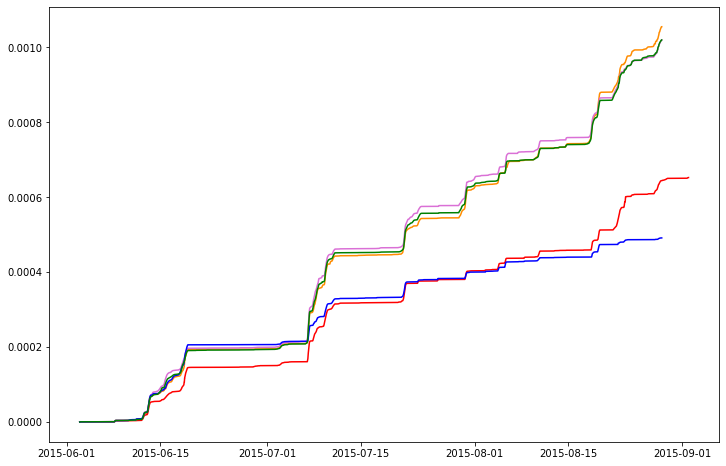

In [15]:
fig,axs = plt.subplots(1,1, figsize=(12,8))

np.cumsum(HMGcamDS_all['PRECT'].values, axis=0)

axs.plot(HMGcamDS_all.time.values,   np.squeeze(np.cumsum(HMGcamDS_all['PRECT'].values, axis=0)), color='darkorange', label='HMG')
axs.plot(HMGv2camDS_all.time.values,   np.squeeze(np.cumsum(HMGv2camDS_all['PRECT'].values, axis=0)), color='red', label='HMGv2')

axs.plot(HTGcamDS_all.time.values,   np.squeeze(np.cumsum(HTGcamDS_all['PRECT'].values, axis=0)), color='orchid', label='HTG')
axs.plot(HTGp5camDS_all.time.values, np.squeeze(np.cumsum(HTGp5camDS_all['PRECT'].values, axis=0)), color='blue', label='HTG*10')
axs.plot(HTG0camDS_all.time.values,  np.squeeze(np.cumsum(HTG0camDS_all['PRECT'].values, axis=0)), color='green', label='HTG*0.5')




## What if we used a different start date? Or otherwise perturbed the initial conditions?

In [6]:
## Read in files 

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir_HMGpert = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HMG_pertlim/'
caseName_HMGpert = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_useTheta_'

yearStrings  = np.asarray(['2015'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc',
                            '-07-05-60585.nc',
                            '-07-14-32985.nc',
                            '-07-23-05385.nc',
                            '-07-31-64185.nc',
                            '-08-09-36585.nc',
                            '-08-18-08985.nc',
                            '-08-26-67785.nc' ])


fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMGpert0 = dataDir_HMGpert+caseName_HMGpert+yearStrings[iYr]+'jja_pertlim00.cam.h1.'+yearStrings[iYr]
    fileStart_atm_HMGpert1 = dataDir_HMGpert+caseName_HMGpert+yearStrings[iYr]+'jja_pertlim01.cam.h1.'+yearStrings[iYr]
    fileStart_atm_HMGpert2 = dataDir_HMGpert+caseName_HMGpert+yearStrings[iYr]+'jja_pertlim02.cam.h1.'+yearStrings[iYr]

    for iFile in range(len(dateEndFiles)):
        fileName_atm_HMGpert0 = fileStart_atm_HMGpert0+dateEndFiles[iFile]
        fileName_atm_HMGpert1 = fileStart_atm_HMGpert1+dateEndFiles[iFile]
        fileName_atm_HMGpert2 = fileStart_atm_HMGpert2+dateEndFiles[iFile]

        with xr.open_dataset(fileName_atm_HMGpert0, decode_times=False) as HMGpert0_camDS:
            HMGpert0_camDS = cesm_correct_time(HMGpert0_camDS)
            HMGpert0_camDS['time'] = HMGpert0_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HMGpert1, decode_times=False) as HMGpert1_camDS:
            HMGpert1_camDS = cesm_correct_time(HMGpert1_camDS)
            HMGpert1_camDS['time'] = HMGpert1_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HMGpert2, decode_times=False) as HMGpert2_camDS:
            HMGpert2_camDS = cesm_correct_time(HMGpert2_camDS)
            HMGpert2_camDS['time'] = HMGpert2_camDS.indexes['time'].to_datetimeindex()


        # Discard the first two days if iFile == 0  
        if iFile==0:
            
            # Account for a different start date
            iTimeStart_v2 = np.where(HMGpert1_camDS.time.values >= HMGcamDS_all.time.values[0])[0]
            timeArr_v2    = np.arange(iTimeStart_v2[0], len(HMGpert1_camDS.time.values))
            
            HMGpert0_camDS = HMGpert0_camDS.isel(time=timeArr_v2)
            HMGpert1_camDS = HMGpert1_camDS.isel(time=timeArr_v2)
            HMGpert2_camDS = HMGpert2_camDS.isel(time=timeArr_v2)

        if fileCount==0:
            HMGcamDS_allPert0   = HMGpert0_camDS
            HMGcamDS_allPert1   = HMGpert1_camDS
            HMGcamDS_allPert2   = HMGpert2_camDS
            
            
        else:     
            HMGcamDS_allPert0   = xr.concat([HMGcamDS_allPert0,HMGpert0_camDS], dim='time')
            HMGcamDS_allPert1   = xr.concat([HMGcamDS_allPert1,HMGpert1_camDS], dim='time')
            HMGcamDS_allPert2   = xr.concat([HMGcamDS_allPert2,HMGpert2_camDS], dim='time')

        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))


Done with file 1 of 11 
Done with file 2 of 11 
Done with file 3 of 11 
Done with file 4 of 11 
Done with file 5 of 11 
Done with file 6 of 11 
Done with file 7 of 11 
Done with file 8 of 11 
Done with file 9 of 11 
Done with file 10 of 11 
Done with file 11 of 11 


In [7]:
## Add other vars to the list

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'

dataDir_HMGpert = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HMG_pertlim/'
caseName_HMGpert = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_useTheta_'

yearStrings  = np.asarray(['2015'])

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG      = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HTG      = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HMGpert1 = dataDir_HMGpert+caseName_HMGpert+yearStrings[iYr]+'jja_pertlim01.cam.h0.'
    fileStart_atm_HMGpert2 = dataDir_HMGpert+caseName_HMGpert+yearStrings[iYr]+'jja_pertlim02.cam.h0.'

    fileName_atm_HMG      = fileStart_atm_HMG+'ExtraVarsAndBudget.nc'
    fileName_atm_HTG      = fileStart_atm_HTG+'ExtraVarsAndBudget.nc'
    fileName_atm_HMGpert1 = fileStart_atm_HMGpert1+'ExtraVarsAndBudget.nc'
    fileName_atm_HMGpert2 = fileStart_atm_HMGpert2+'ExtraVarsAndBudget.nc'
    
        
    with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
        HMG_camDS = cesm_correct_time(HMG_camDS)
        HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
        HTG_camDS = cesm_correct_time(HTG_camDS)
        HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
    with xr.open_dataset(fileName_atm_HMGpert1, decode_times=False) as HMGpert1_camDS:
        HMGpert1_camDS = cesm_correct_time(HMGpert1_camDS)
        HMGpert1_camDS['time'] = HMGpert1_camDS.indexes['time'].to_datetimeindex() 
    with xr.open_dataset(fileName_atm_HMGpert2, decode_times=False) as HMGpert2_camDS:
        HMGpert2_camDS = cesm_correct_time(HMGpert2_camDS)
        HMGpert2_camDS['time'] = HMGpert2_camDS.indexes['time'].to_datetimeindex() 
            
    # Discard first two days 
    iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

    HTG_camDS      = HTG_camDS.isel(time=timeArr)
    HMG_camDS      = HMG_camDS.isel(time=timeArr)
    HMGpert1_camDS = HMGpert1_camDS.isel(time=timeArr)
    HMGpert2_camDS = HMGpert2_camDS.isel(time=timeArr)


    if fileCount==0:
        HTGcamDS_realSfcExtra   = HTG_camDS
        HMGcamDS_realSfcExtra   = HMG_camDS  
        HMGpert1_realSfcExtra   = HMGpert1_camDS
        HMGpert2_realSfcExtra   = HMGpert2_camDS
    else: 
        HTGcamDS_realSfcExtra   = xr.concat([HTGcamDS_realSfcExtra,HTG_camDS], dim='time')
        HMGcamDS_realSfcExtra   = xr.concat([HMGcamDS_realSfcExtra,HMG_camDS], dim='time')
        HMGpert1_realSfcExtra = xr.concat([HMGpert1_realSfcExtra,HMGpert1_camDS], dim='time')
        HMGpert2_realSfcExtra = xr.concat([HMGpert2_realSfcExtra,HMGpert2_camDS], dim='time')
            
    fileCount = fileCount+1
    print('Done with file %i of %i '% (fileCount,len(yearStrings)))


Done with file 1 of 1 


In [8]:
# Merge into larger dataset
HTGcamDS_all       = xr.merge([HTGcamDS_all,   HTGcamDS_realSfcExtra])
HMGcamDS_all       = xr.merge([HMGcamDS_all,   HMGcamDS_realSfcExtra])
HMGcamDS_allPert1  = xr.merge([HMGcamDS_allPert1,  HMGpert1_realSfcExtra])
HMGcamDS_allPert2  = xr.merge([HMGcamDS_allPert2,  HMGpert2_realSfcExtra])


In [4]:
# ## Read in files that use a new start date (5/29/15)

# # This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
# dataDir_newHMG = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HMG_newStartDate/'
# caseName_HMGv2 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_useTheta_'

# yearStrings  = np.asarray(['2015'])
# dateEndFiles = np.asarray([ '-05-29-84585.nc',
#                             '-06-07-56985.nc',
#                             '-06-16-29385.nc',
#                             '-06-25-01785.nc',
#                             '-07-03-60585.nc',
#                             '-07-12-32985.nc',
#                             '-07-21-05385.nc' ])  # Didn't finish running in time 
# #                             '-07-29-64185.nc',
# #                             '-08-07-36585.nc',
# #                             '-08-16-08985.nc',
# #                             '-08-24-67785.nc' ])

# fileCount=0
# for iYr in range(len(yearStrings)): 

#     fileStart_atm_HMGv2 = dataDir_newHMG+caseName_HMGv2+yearStrings[iYr]+'jja_v2.cam.h1.'+yearStrings[iYr]

#     for iFile in range(len(dateEndFiles)):

#         fileName_atm_HMGv2 = fileStart_atm_HMGv2+dateEndFiles[iFile]

#         with xr.open_dataset(fileName_atm_HMGv2, decode_times=False) as HMGv2_camDS:
#             HMGv2_camDS = cesm_correct_time(HMGv2_camDS)
#             HMGv2_camDS['time'] = HMGv2_camDS.indexes['time'].to_datetimeindex()


#         # Discard the first two days if iFile == 0  
#         if iFile==0:
            
#             # Account for a different start date
#             iTimeStart_v2 = np.where(HMGv2_camDS.time.values >= HMGcamDS_all.time.values[0])[0]
#             timeArr_v2    = np.arange(iTimeStart_v2[0], len(HMGv2_camDS.time.values))
#             HMGv2_camDS   = HMGv2_camDS.isel(time=timeArr_v2)

#         if fileCount==0:
#             HMGv2camDS_all   = HMGv2_camDS
            
            
#         else:           
#             HMGv2camDS_all   = xr.concat([HMGv2camDS_all,HMGv2_camDS], dim='time')

        
#         fileCount = fileCount+1
#         print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))


Done with file 1 of 7 
Done with file 2 of 7 
Done with file 3 of 7 
Done with file 4 of 7 
Done with file 5 of 7 
Done with file 6 of 7 
Done with file 7 of 7 


In [38]:
# ## Get same end time as well... 
# iTimeEnd_v2          = np.where(HMGcamDS_all.time.values == HMGv2camDS_all.time.values[-1])[0]

# # HMGcamDS_all_newDate = HMGcamDS_all.isel(time=np.arange(0, int(iTimeEnd_v2)+1))
# HMGcamDS_allPert_newDate = HMGcamDS_allPert.isel(time=np.arange(0, int(iTimeEnd_v2)+1))
# # HTGcamDS_all_newDate = HTGcamDS_all.isel(time=np.arange(0, int(iTimeEnd_v2)+1))


In [10]:
# Now compute the BL depth and save it to the larger CAM datasets 
PBLdepth_hmg = PBLHasMaxDZ(HMGcamDS_all, 'THETAL')
PBLdepth_htg = PBLHasMaxDZ(HTGcamDS_all, 'THETAL')
PBLdepth_hmgPert1 = PBLHasMaxDZ(HMGcamDS_allPert1, 'THETAL')
PBLdepth_hmgPert2 = PBLHasMaxDZ(HMGcamDS_allPert2, 'THETAL')
print('Done computing PBL depth with THETAL')

# Add above to each dataset
HMGcamDS_all['PBLdepth']       = (('time'), PBLdepth_hmg)
HTGcamDS_all['PBLdepth']       = (('time'), PBLdepth_htg)
HMGcamDS_allPert1['PBLdepth']  = (('time'), PBLdepth_hmgPert1)
HMGcamDS_allPert2['PBLdepth']  = (('time'), PBLdepth_hmgPert2)



Done computing PBL depth with THETAL


In [13]:
del PBLdepth_hmg
del PBLdepth_htg
del PBLdepth_hmgPert1
del PBLdepth_hmgPert2

# Now compute the BL depth and save it to the larger CAM datasets 
PBLdepth_hmg = PBLHasMaxDZ(HMGcamDS_all, 'Q')
PBLdepth_htg = PBLHasMaxDZ(HTGcamDS_all, 'Q')
PBLdepth_hmgPert1 = PBLHasMaxDZ(HMGcamDS_allPert1, 'Q')
PBLdepth_hmgPert2 = PBLHasMaxDZ(HMGcamDS_allPert2, 'Q')
print('Done computing PBL depth with Q')

# Add above to each dataset
HMGcamDS_all['PBLdepth_q']       = (('time'), PBLdepth_hmg)
HTGcamDS_all['PBLdepth_q']       = (('time'), PBLdepth_htg)
HMGcamDS_allPert1['PBLdepth_q']  = (('time'), PBLdepth_hmgPert1)
HMGcamDS_allPert2['PBLdepth_q']  = (('time'), PBLdepth_hmgPert2)



Done computing PBL depth with Q


In [15]:
del PBLdepth_hmg
del PBLdepth_htg
del PBLdepth_hmgPert1
del PBLdepth_hmgPert2

# Now compute the BL depth and save it to the larger CAM datasets 
PBLdepth_hmg = PBLHasMaxDZ_abs(HMGcamDS_all, 'Q')
PBLdepth_htg = PBLHasMaxDZ_abs(HTGcamDS_all, 'Q')
PBLdepth_hmgPert1 = PBLHasMaxDZ_abs(HMGcamDS_allPert1, 'Q')
PBLdepth_hmgPert2 = PBLHasMaxDZ_abs(HMGcamDS_allPert2, 'Q')
print('Done computing PBL depth with Qabs')

# Add above to each dataset
HMGcamDS_all['PBLdepth_qAbs']       = (('time'), PBLdepth_hmg)
HTGcamDS_all['PBLdepth_qAbs']       = (('time'), PBLdepth_htg)
HMGcamDS_allPert1['PBLdepth_qAbs']  = (('time'), PBLdepth_hmgPert1)
HMGcamDS_allPert2['PBLdepth_qAbs']  = (('time'), PBLdepth_hmgPert2)



Done computing PBL depth with Qabs


In [16]:
## Test out using just hourly means, not the five minute data...

HMGcamDS_all_newDateHourly = HMGcamDS_all.resample(time="1H").mean()
HTGcamDS_all_newDateHourly = HTGcamDS_all.resample(time="1H").mean()
# HMGv2camDS_allHourly       = HMGv2camDS_all.resample(time="1H").mean()
HMGcamDS_allPert0_newDateHourly = HMGcamDS_allPert0.resample(time="1H").mean()
HMGcamDS_allPert1_newDateHourly = HMGcamDS_allPert1.resample(time="1H").mean()
HMGcamDS_allPert2_newDateHourly = HMGcamDS_allPert2.resample(time="1H").mean()


(-2500.0, 5500.0)

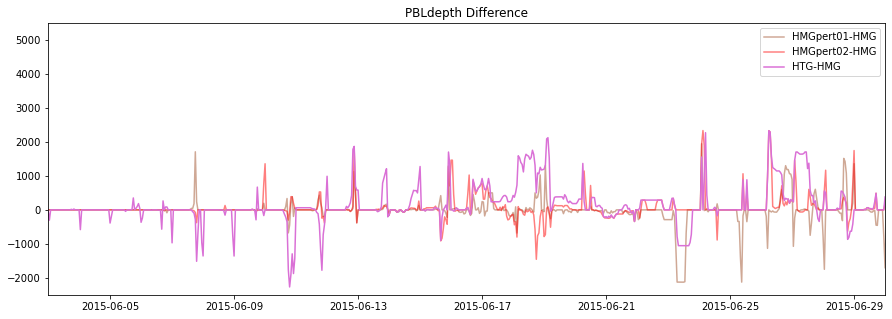

In [38]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PBLdepth'

# axs.plot(HMGv2camDS_allHourly.time.values,
#          np.squeeze(HMGv2camDS_allHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='red', label='HMG_v2-HMG')

axs.plot(HMGcamDS_allPert1_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='sienna', alpha=0.5, label='HMGpert01-HMG')

axs.plot(HMGcamDS_allPert2_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='red', alpha=0.5, label='HMGpert02-HMG')

# axs.plot(HMGcamDS_allPert0_newDateHourly.time.values,
#          np.squeeze(HMGcamDS_allPert0_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='dodgerblue', label='HMGpert00-HMG')

# axs.plot(HMGcamDS_allPert2_newDateHourly.time.values,
#          np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_allPert1_newDateHourly[varSelPlot].values), 
#          color='olive', label='HMGpert02-HMGpert01')

axs.plot(HTGcamDS_all_newDateHourly.time.values,
         np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='orchid', label='HTG-HMG')

axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,30)])
axs.legend()
axs.set_title(varSelPlot+' Difference')

# axs.set_ylim([0,0.5])
axs.set_ylim([-2500,5500])
# axs.axhline(0,color='grey')


Text(0.5, 1.0, 'PBLH')

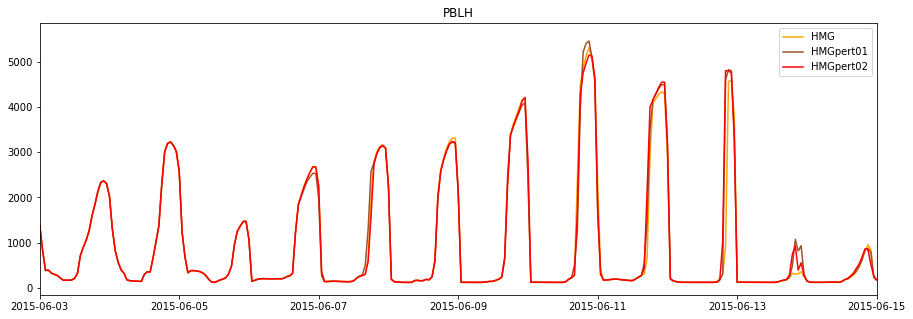

In [24]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PBLH'
levSel     = None

axs.plot(HMGcamDS_all_newDateHourly.time.values,  np.squeeze(HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orange', label='HMG')
# axs.plot(HMGv2camDS_allHourly.time.values,        np.squeeze(HMGv2camDS_allHourly[varSelPlot].values[:,levSel]), color='red', label='HMG_v2')
axs.plot(HMGcamDS_allPert1_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values[:,levSel]), color='sienna', label='HMGpert01')
axs.plot(HMGcamDS_allPert2_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values[:,levSel]), color='red', label='HMGpert02')
# axs.plot(HTGcamDS_all_newDateHourly.time.values,  np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orchid', label='HTG')

axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
# axs.set_xlim([datetime.date(2015,7,3), datetime.date(2015,8,1)])

axs.legend()
axs.set_title(varSelPlot)

# axs.set_ylim([0,5500])


Text(0.5, 1.0, 'PBLdepth')

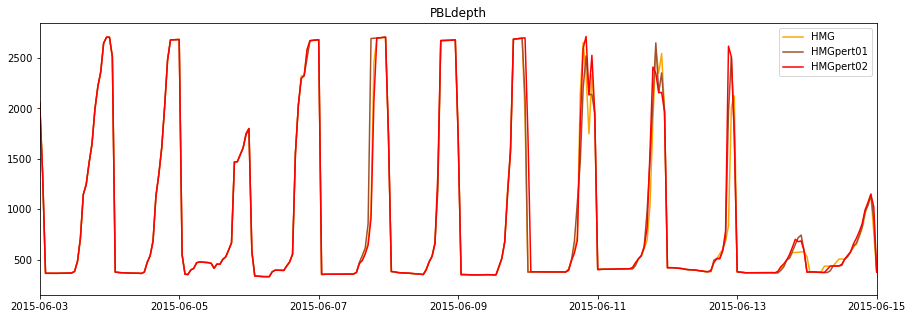

In [21]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PBLdepth'
levSel     = None

axs.plot(HMGcamDS_all_newDateHourly.time.values,  np.squeeze(HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orange', label='HMG')
# axs.plot(HMGv2camDS_allHourly.time.values,        np.squeeze(HMGv2camDS_allHourly[varSelPlot].values[:,levSel]), color='red', label='HMG_v2')
axs.plot(HMGcamDS_allPert1_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values[:,levSel]), color='sienna', label='HMGpert01')
axs.plot(HMGcamDS_allPert2_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values[:,levSel]), color='red', label='HMGpert02')
# axs.plot(HTGcamDS_all_newDateHourly.time.values,  np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orchid', label='HTG')

axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
# axs.set_xlim([datetime.date(2015,7,3), datetime.date(2015,8,1)])

axs.legend()
axs.set_title(varSelPlot)

# axs.set_ylim([0,5500])


Text(0.5, 1.0, 'PBLdepth_qAbs')

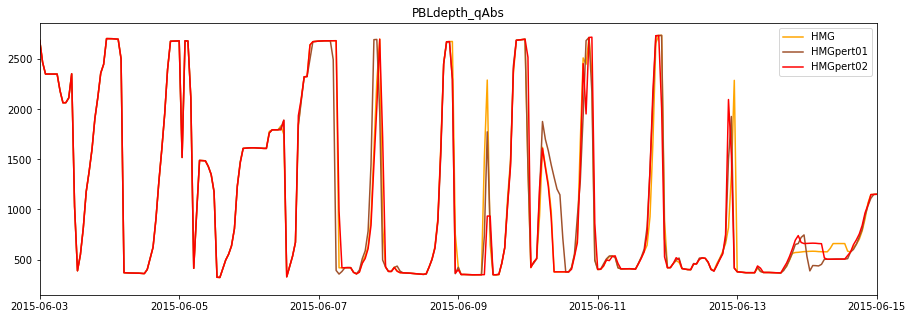

In [20]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PBLdepth_qAbs'
levSel     = None

axs.plot(HMGcamDS_all_newDateHourly.time.values,  np.squeeze(HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orange', label='HMG')
# axs.plot(HMGv2camDS_allHourly.time.values,        np.squeeze(HMGv2camDS_allHourly[varSelPlot].values[:,levSel]), color='red', label='HMG_v2')
axs.plot(HMGcamDS_allPert1_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values[:,levSel]), color='sienna', label='HMGpert01')
axs.plot(HMGcamDS_allPert2_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values[:,levSel]), color='red', label='HMGpert02')
# axs.plot(HTGcamDS_all_newDateHourly.time.values,  np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orchid', label='HTG')

axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
# axs.set_xlim([datetime.date(2015,7,3), datetime.date(2015,8,1)])

axs.legend()
axs.set_title(varSelPlot)

# axs.set_ylim([0,5500])


Text(0.5, 1.0, 'PBLdepth_q')

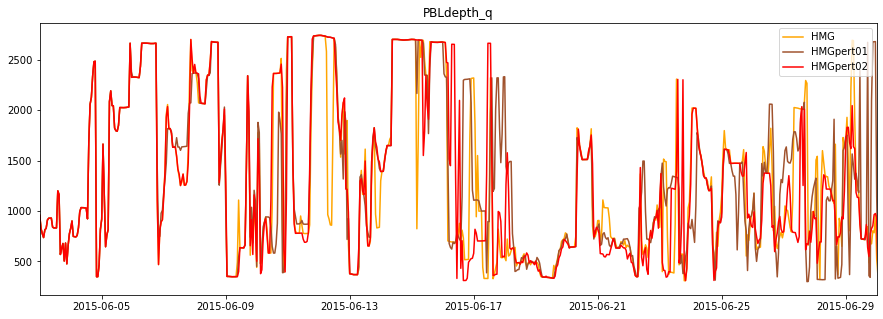

In [27]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PBLdepth_q'
levSel     = None

axs.plot(HMGcamDS_all_newDateHourly.time.values,  np.squeeze(HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orange', label='HMG')
# axs.plot(HMGv2camDS_allHourly.time.values,        np.squeeze(HMGv2camDS_allHourly[varSelPlot].values[:,levSel]), color='red', label='HMG_v2')
axs.plot(HMGcamDS_allPert1_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values[:,levSel]), color='sienna', label='HMGpert01')
axs.plot(HMGcamDS_allPert2_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values[:,levSel]), color='red', label='HMGpert02')
# axs.plot(HTGcamDS_all_newDateHourly.time.values,  np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orchid', label='HTG')

axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,30)])
# axs.set_xlim([datetime.date(2015,7,3), datetime.date(2015,8,1)])

axs.legend()
axs.set_title(varSelPlot)

# axs.set_ylim([0,5500])


Text(0.5, 1.0, 'THLP2_CLUBB')

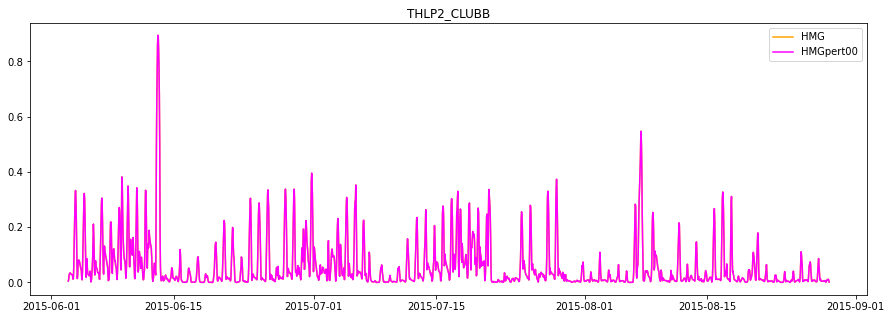

In [27]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'THLP2_CLUBB'
levSel     = -1

axs.plot(HMGcamDS_all_newDateHourly.time.values,  np.squeeze(HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orange', label='HMG')
# axs.plot(HMGv2camDS_allHourly.time.values,        np.squeeze(HMGv2camDS_allHourly[varSelPlot].values[:,levSel]), color='red', label='HMG_v2')
axs.plot(HMGcamDS_allPert0_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert0_newDateHourly[varSelPlot].values[:,levSel]), color='magenta', label='HMGpert00')

# axs.plot(HMGcamDS_allPert1_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values[:,levSel]), color='sienna', label='HMGpert01')
# axs.plot(HMGcamDS_allPert2_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values[:,levSel]), color='red', label='HMGpert02')
# axs.plot(HTGcamDS_all_newDateHourly.time.values,  np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orchid', label='HTG')

# axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
axs.legend()
axs.set_title(varSelPlot)

# axs.set_ylim([0,0.5])


(0.0, 5500.0)

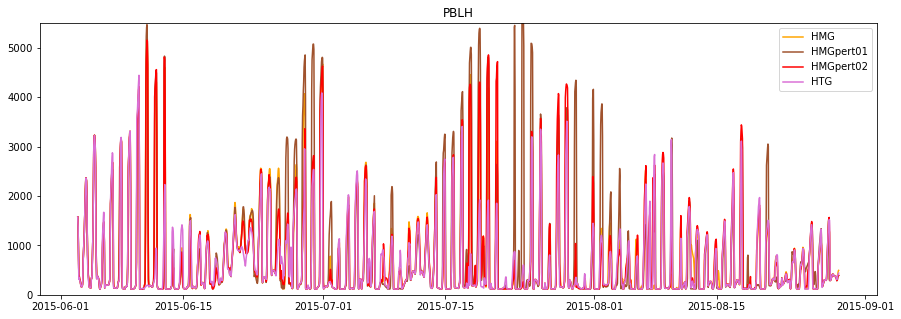

In [9]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PBLH'
levSel     = None

axs.plot(HMGcamDS_all_newDateHourly.time.values,  np.squeeze(HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orange', label='HMG')
# axs.plot(HMGv2camDS_allHourly.time.values,        np.squeeze(HMGv2camDS_allHourly[varSelPlot].values[:,levSel]), color='red', label='HMG_v2')
axs.plot(HMGcamDS_allPert1_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values[:,levSel]), color='sienna', label='HMGpert01')
axs.plot(HMGcamDS_allPert2_newDateHourly.time.values, np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values[:,levSel]), color='red', label='HMGpert02')
axs.plot(HTGcamDS_all_newDateHourly.time.values,  np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), color='orchid', label='HTG')

# axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
# axs.set_xlim([datetime.date(2015,7,3), datetime.date(2015,8,1)])

axs.legend()
axs.set_title(varSelPlot)

axs.set_ylim([0,5500])


(-2000.0, 5500.0)

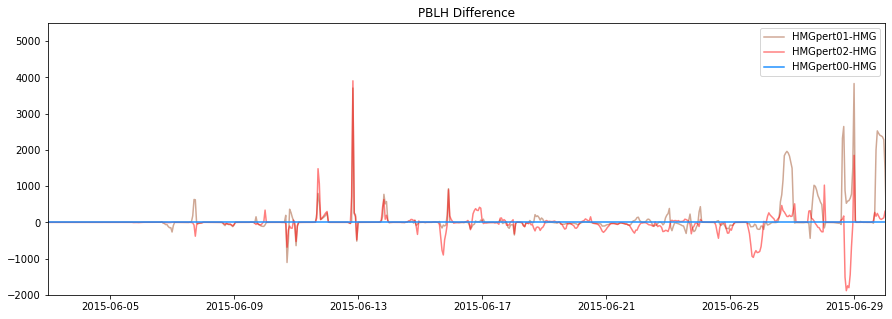

In [26]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PBLH'

# axs.plot(HMGv2camDS_allHourly.time.values,
#          np.squeeze(HMGv2camDS_allHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='red', label='HMG_v2-HMG')

axs.plot(HMGcamDS_allPert1_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='sienna', alpha=0.5, label='HMGpert01-HMG')

axs.plot(HMGcamDS_allPert2_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='red', alpha=0.5, label='HMGpert02-HMG')

axs.plot(HMGcamDS_allPert0_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert0_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='dodgerblue', label='HMGpert00-HMG')

# axs.plot(HMGcamDS_allPert2_newDateHourly.time.values,
#          np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_allPert1_newDateHourly[varSelPlot].values), 
#          color='olive', label='HMGpert02-HMGpert01')

# axs.plot(HTGcamDS_all_newDateHourly.time.values,
#          np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='orchid', label='HTG-HMG')

axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,30)])
axs.legend()
axs.set_title(varSelPlot+' Difference')

# axs.set_ylim([0,0.5])
axs.set_ylim([-2000,5500])
# axs.axhline(0,color='grey')


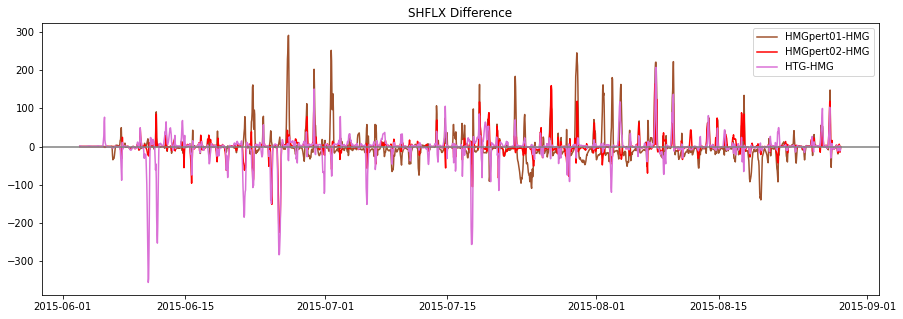

In [65]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'SHFLX'

# axs.plot(HMGv2camDS_allHourly.time.values,
#          np.squeeze(HMGv2camDS_allHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='red', label='HMG_v2-HMG')

axs.plot(HMGcamDS_allPert1_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='sienna', label='HMGpert01-HMG')
axs.plot(HMGcamDS_allPert2_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='red', label='HMGpert02-HMG')
axs.plot(HTGcamDS_all_newDateHourly.time.values,
         np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='orchid', label='HTG-HMG')

# axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
axs.legend()
axs.set_title(varSelPlot+' Difference')

# axs.set_ylim([0,0.5])
# axs.set_ylim([-5500,5500])
axs.axhline(0,color='grey')


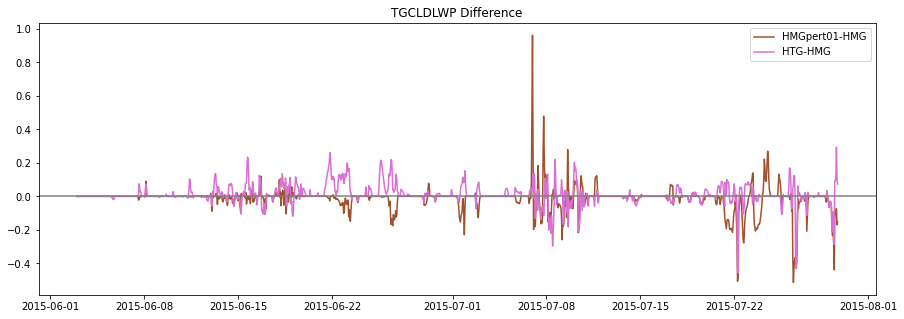

In [50]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'TGCLDLWP'

# axs.plot(HMGv2camDS_allHourly.time.values,
#          np.squeeze(HMGv2camDS_allHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='red', label='HMG_v2-HMG')

axs.plot(HMGcamDS_allPert_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='sienna', label='HMGpert01-HMG')

axs.plot(HTGcamDS_all_newDateHourly.time.values,
         np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='orchid', label='HTG-HMG')

# axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
axs.legend()
axs.set_title(varSelPlot+' Difference')

# axs.set_ylim([0,0.5])
# axs.set_ylim([-5500,5500])
axs.axhline(0,color='grey')


Text(0.5, 1.0, 'TREFHT Difference')

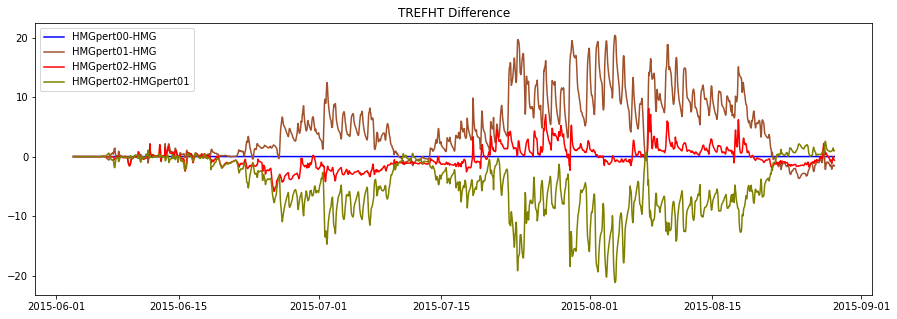

In [40]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'TREFHT'

# axs.plot(HMGv2camDS_allHourly.time.values,
#          np.squeeze(HMGv2camDS_allHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='red', label='HMG_v2-HMG')
axs.plot(HMGcamDS_allPert0_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert0_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='blue', label='HMGpert00-HMG')

axs.plot(HMGcamDS_allPert1_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='sienna', label='HMGpert01-HMG')

axs.plot(HMGcamDS_allPert2_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='red', label='HMGpert02-HMG')

axs.plot(HMGcamDS_allPert2_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_allPert1_newDateHourly[varSelPlot].values), 
         color='olive', label='HMGpert02-HMGpert01')

# axs.plot(HTGcamDS_all_newDateHourly.time.values,
#          np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='orchid', label='HTG-HMG')

# axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
axs.legend()
axs.set_title(varSelPlot+' Difference')

# axs.set_ylim([0,0.5])
# axs.set_ylim([-5500,5500])
# axs.axhline(0,color='grey')


Text(0.5, 1.0, 'PRECT Difference')

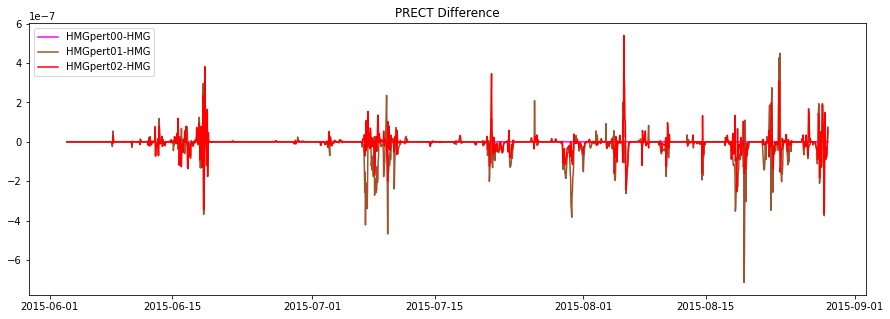

In [64]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PRECT'

# axs.plot(HMGv2camDS_allHourly.time.values,
#          np.squeeze(HMGv2camDS_allHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='red', label='HMG_v2-HMG')
axs.plot(HMGcamDS_allPert0_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert0_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='magenta', label='HMGpert00-HMG')

axs.plot(HMGcamDS_allPert1_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='sienna', label='HMGpert01-HMG')

axs.plot(HMGcamDS_allPert2_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
         color='red', label='HMGpert02-HMG')

# axs.plot(HTGcamDS_all_newDateHourly.time.values,
#          np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values), 
#          color='orchid', label='HTG-HMG')

# axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
axs.legend()
axs.set_title(varSelPlot+' Difference')

# axs.set_ylim([0,0.5])
# axs.set_ylim([-5500,5500])
# axs.axhline(0,color='grey')


671.8611996620893


Text(0.5, 1.0, 'U Difference @ ilev=-20')

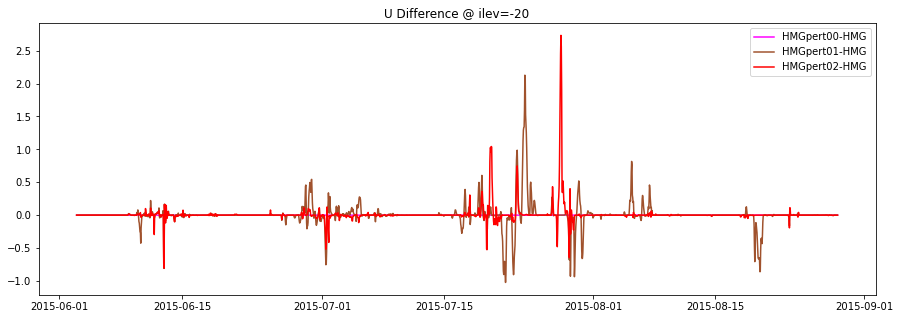

In [38]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

varSelPlot = 'U'
levSel=-20
print(HMGcamDS_allPert0_newDateHourly.lev.values[levSel])

axs.plot(HMGcamDS_allPert0_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert0_newDateHourly[varSelPlot].values[:,levSel] - HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), 
         color='magenta', label='HMGpert00-HMG')

axs.plot(HMGcamDS_allPert1_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert1_newDateHourly[varSelPlot].values[:,levSel] - HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), 
         color='sienna', label='HMGpert01-HMG')

axs.plot(HMGcamDS_allPert2_newDateHourly.time.values,
         np.squeeze(HMGcamDS_allPert2_newDateHourly[varSelPlot].values[:,levSel] - HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), 
         color='red', label='HMGpert02-HMG')

# axs.plot(HTGcamDS_all_newDateHourly.time.values,
#          np.squeeze(HTGcamDS_all_newDateHourly[varSelPlot].values[:,levSel] - HMGcamDS_all_newDateHourly[varSelPlot].values[:,levSel]), 
#          color='orchid', label='HTG-HMG')

# axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
axs.legend()
axs.set_title(varSelPlot+' Difference @ ilev='+str(levSel))

# axs.set_ylim([0,0.5])
# axs.set_ylim([-5500,5500])
# axs.axhline(0,color='grey')


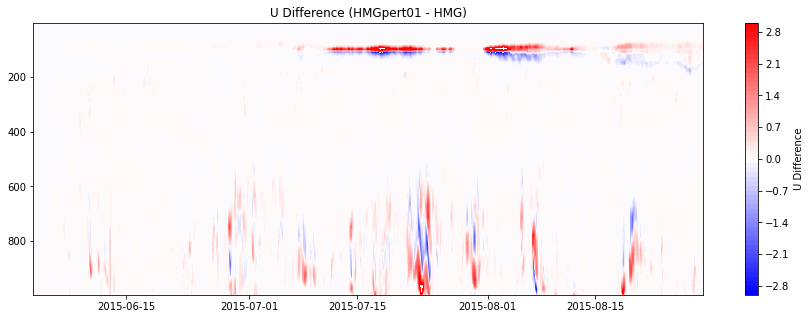

In [60]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

varSelPlot = 'U'
levs       = np.arange(-3, 3.1, 0.1)          # Levels for U diffs 
# levs       = np.arange(-0.02,0.021,0.001)   # Levels for Q diffs 

diffVar = HMGcamDS_allPert1_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values

c = axs.contourf(HMGcamDS_allPert1_newDateHourly.time.values, HMGcamDS_allPert1_newDateHourly.lev.values, 
             np.squeeze(diffVar.transpose()), levs, cmap='bwr')
axs.invert_yaxis()
axs.set_title(varSelPlot+' Difference (HMGpert01 - HMG)')

plt.colorbar(c, label=varSelPlot+' Difference')


TypeError: Length of y (64) must match number of rows in z (65)

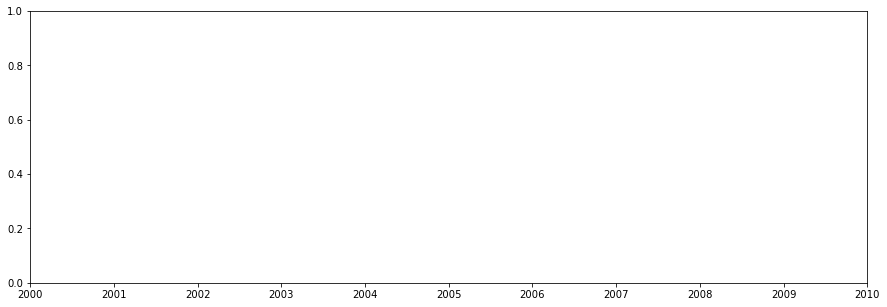

In [75]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

varSelPlot = 'CLOUDCOVER_CLUBB'
levs = np.arange(-1,1.01,0.01)
# levs       = np.arange(-3, 3.1, 0.1)          # Levels for U diffs 
# levs       = np.arange(-20,20.1,0.1)        # Levels for T diffs 
# levs       = np.arange(-0.02,0.021,0.001)   # Levels for Q diffs 

diffVar = HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values

c = axs.contourf(HMGcamDS_allPert2_newDateHourly.time.values, HMGcamDS_allPert2_newDateHourly.lev.values, 
             np.squeeze(diffVar.transpose()), levs, cmap='bwr')
axs.invert_yaxis()
axs.set_title(varSelPlot+' Difference (HMGpert02 - HMG)')

plt.colorbar(c, label=varSelPlot+' Difference')


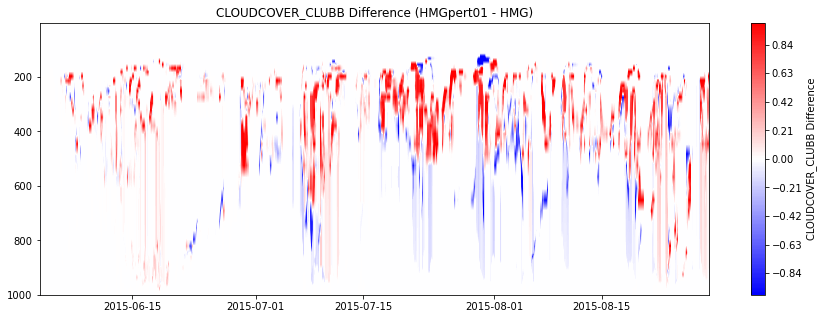

In [77]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

varSelPlot = 'CLOUDCOVER_CLUBB'
levs = np.arange(-1,1.01,0.01)
# levs       = np.arange(-3, 3.1, 0.1)          # Levels for U diffs 
# levs       = np.arange(-20,20.1,0.1)        # Levels for T diffs 
# levs       = np.arange(-0.02,0.021,0.001)   # Levels for Q diffs 

diffVar = HMGcamDS_allPert1_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values

c = axs.contourf(HMGcamDS_allPert1_newDateHourly.time.values, HMGcamDS_allPert1_newDateHourly.ilev.values, 
             np.squeeze(diffVar.transpose()), levs, cmap='bwr')
axs.invert_yaxis()
axs.set_title(varSelPlot+' Difference (HMGpert01 - HMG)')

plt.colorbar(c, label=varSelPlot+' Difference')


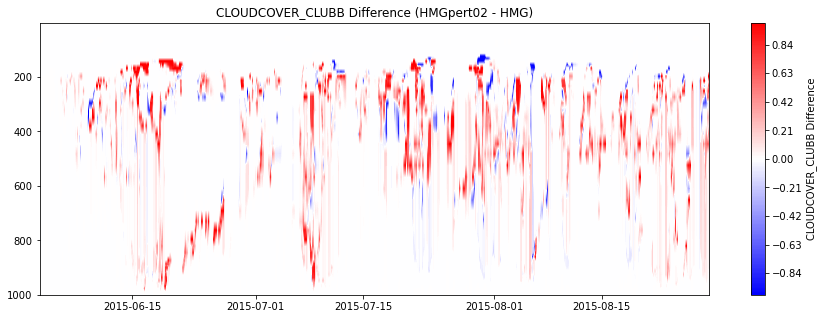

In [76]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

varSelPlot = 'CLOUDCOVER_CLUBB'
levs = np.arange(-1,1.01,0.01)
# levs       = np.arange(-3, 3.1, 0.1)          # Levels for U diffs 
# levs       = np.arange(-20,20.1,0.1)        # Levels for T diffs 
# levs       = np.arange(-0.02,0.021,0.001)   # Levels for Q diffs 

diffVar = HMGcamDS_allPert2_newDateHourly[varSelPlot].values - HMGcamDS_all_newDateHourly[varSelPlot].values

c = axs.contourf(HMGcamDS_allPert2_newDateHourly.time.values, HMGcamDS_allPert2_newDateHourly.ilev.values, 
             np.squeeze(diffVar.transpose()), levs, cmap='bwr')
axs.invert_yaxis()
axs.set_title(varSelPlot+' Difference (HMGpert02 - HMG)')

plt.colorbar(c, label=varSelPlot+' Difference')


### How sensitive is the PBLH on supposedly "sensitive" days?

In [11]:
## Convert to local times...

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all_newDateHourly['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
# HTG10camDS_realSfcExtra_local = HTG10camDS_realSfcExtra_local.assign_coords({"time": localTimes})
HMGcamDS_all_newDateHourly      = HMGcamDS_all_newDateHourly.assign_coords({"time": localTimes})
HTGcamDS_all_newDateHourly      = HTGcamDS_all_newDateHourly.assign_coords({"time": localTimes})
HMGcamDS_allPert1_newDateHourly = HMGcamDS_allPert1_newDateHourly.assign_coords({"time": localTimes})
HMGcamDS_allPert2_newDateHourly = HMGcamDS_allPert2_newDateHourly.assign_coords({"time": localTimes})


In [12]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_all_newDateHourly['time.year'].values,
                                                                HMGcamDS_all_newDateHourly['time.month'].values, 
                                                                HMGcamDS_all_newDateHourly['time.day'].values])


HMGcamDS_all_newDateHourly.coords['year_month_day']       = ('time', month_day_idx)
HTGcamDS_all_newDateHourly.coords['year_month_day']       = ('time', month_day_idx)
HMGcamDS_allPert1_newDateHourly.coords['year_month_day']  = ('time', month_day_idx)
HMGcamDS_allPert2_newDateHourly.coords['year_month_day']  = ('time', month_day_idx)


In [13]:
## Use files automatically created with other script
filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_PBLH_HTGonlyDefined.csv'
# filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_PBLH_HTG10onlyDefined.csv'

cssDF    = pd.read_csv(filePath, header=0, usecols=[1,2], names=['pos', 'neg'])

# Get dates for LWP positive days:
cssDF.pos = pd.to_datetime(cssDF.pos, format="%Y-%m-%d")
cssDF.neg = pd.to_datetime(cssDF.neg, format="%Y-%m-%d")

# Turn into an xarray dataset (more familiar with that)
cssDS   = cssDF.to_xarray()



In [14]:
# Get just 2015
i2015_pos = np.where(cssDS['pos.year']==2015)[0]
i2015_neg = np.where(cssDS['neg.year']==2015)[0]

posDays = cssDS.isel(index=i2015_pos)
negDays = cssDS.isel(index=i2015_neg)


In [15]:
## Get hourly means from those sensitive days only 
numDays_highPct = len(np.where(np.isfinite(posDays['pos.month']))[0])
numDays_lowPct  = len(np.where(np.isfinite(negDays['neg.month']))[0])

iTimes_highPct = []
for iTime in range(numDays_highPct):
    iKeepTimes = np.where((HMGcamDS_all_newDateHourly['time.year'] ==posDays['pos.year'].values[iTime]) &
                          (HMGcamDS_all_newDateHourly['time.month']==posDays['pos.month'].values[iTime]) & 
                          (HMGcamDS_all_newDateHourly['time.day']  ==posDays['pos.day'].values[iTime]))[0]    
    iTimes_highPct = np.append(iTimes_highPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_all_newDateHourly_highPct     = HMGcamDS_all_newDateHourly.isel(time=iTimes_highPct)
HTGcamDS_all_newDateHourly_highPct     = HTGcamDS_all_newDateHourly.isel(time=iTimes_highPct)
HMGcamDS_allPert1_newDateHourly_highPct = HMGcamDS_allPert1_newDateHourly.isel(time=iTimes_highPct)
HMGcamDS_allPert2_newDateHourly_highPct = HMGcamDS_allPert2_newDateHourly.isel(time=iTimes_highPct)


iTimes_lowPct = []
for iTime in range(numDays_lowPct):
    iKeepTimes = np.where((HMGcamDS_all_newDateHourly['time.year'] ==negDays['neg.year'].values[iTime]) &
                          (HMGcamDS_all_newDateHourly['time.month']==negDays['neg.month'].values[iTime]) & 
                          (HMGcamDS_all_newDateHourly['time.day']  ==negDays['neg.day'].values[iTime]))[0]    
    iTimes_lowPct = np.append(iTimes_lowPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_all_newDateHourly_lowPct     = HMGcamDS_all_newDateHourly.isel(time=iTimes_lowPct)
HTGcamDS_all_newDateHourly_lowPct     = HTGcamDS_all_newDateHourly.isel(time=iTimes_lowPct)
HMGcamDS_allPert1_newDateHourly_lowPct = HMGcamDS_allPert1_newDateHourly.isel(time=iTimes_lowPct)
HMGcamDS_allPert2_newDateHourly_lowPct = HMGcamDS_allPert2_newDateHourly.isel(time=iTimes_lowPct)



In [16]:
posDates = np.unique(HMGcamDS_all_newDateHourly_highPct.year_month_day)
negDates = np.unique(HMGcamDS_all_newDateHourly_lowPct.year_month_day)

nPos = len(posDates)
nNeg = len(negDates)

print('Number of positive days: ',nPos)
print('Number of negative days: ',nNeg)

Number of positive days:  14
Number of negative days:  19


ValueError: 'lilac' is not a valid value for color

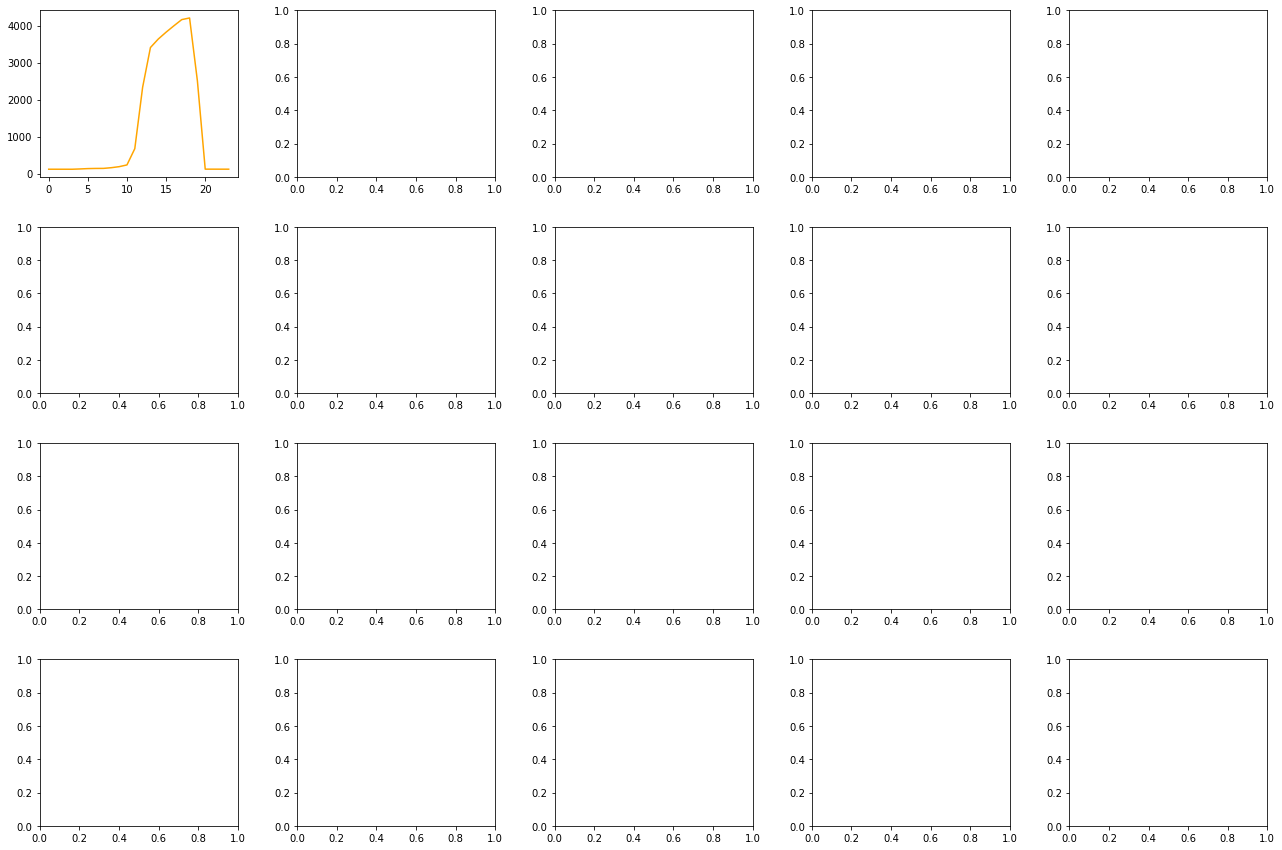

In [19]:
## Plot diurnal cycles for LWP-increase days 

# fig,axs = plt.subplots(3,5, figsize=(22,10))
fig,axs = plt.subplots(4,5, figsize=(22,15))

axs     = axs.ravel()
fig.subplots_adjust(hspace=0.3, wspace=0.3)

varSelPlot = 'PBLH'

for iDay in range(nPos):
    #Select this time in array 
    iselDay = np.where((HMGcamDS_all_newDateHourly_highPct['time.year']  == posDates[iDay][0]) & 
                       (HMGcamDS_all_newDateHourly_highPct['time.month'] == posDates[iDay][1]) & 
                       (HMGcamDS_all_newDateHourly_highPct['time.day']   == posDates[iDay][2]))[0]
    
    # Get hourly means for just this selected day
    selDayHMG      = HMGcamDS_all_newDateHourly_highPct.isel(time=iselDay)
    selDayHTG      = HTGcamDS_all_newDateHourly_highPct.isel(time=iselDay)
    selDayHMGpert1 = HMGcamDS_allPert1_newDateHourly_highPct.isel(time=iselDay)
    selDayHMGpert2 = HMGcamDS_allPert2_newDateHourly_highPct.isel(time=iselDay)
    
    axs[iDay].plot(np.arange(24), np.squeeze(selDayHMG[varSelPlot].values),     color='orange', label='HMG')
    axs[iDay].plot(np.arange(24), np.squeeze(selDayHTG[varSelPlot].values),     color='lilac', label='HTG')
    axs[iDay].plot(np.arange(24), np.squeeze(selDayHMGpert1[varSelPlot].values), color='sienna', label='HMGpert01')
    axs[iDay].plot(np.arange(24), np.squeeze(selDayHMGpert2[varSelPlot].values), color='red',    label='HMGpert02')
    
    if iDay==0:
        axs[iDay].set_title(varSelPlot+'\n'+str(posDates[iDay]))
        axs[iDay].legend()
    else:
        axs[iDay].set_title(str(posDates[iDay]))
        
    #set a consistent y limit
    axs[iDay].set_ylim([0,6500])
        
        
axs[0].set_ylabel(HMGcamDS_all[varSelPlot].units)
axs[5].set_ylabel(HMGcamDS_all[varSelPlot].units)
axs[10].set_ylabel(HMGcamDS_all[varSelPlot].units)


Text(0, 0.5, 'm')

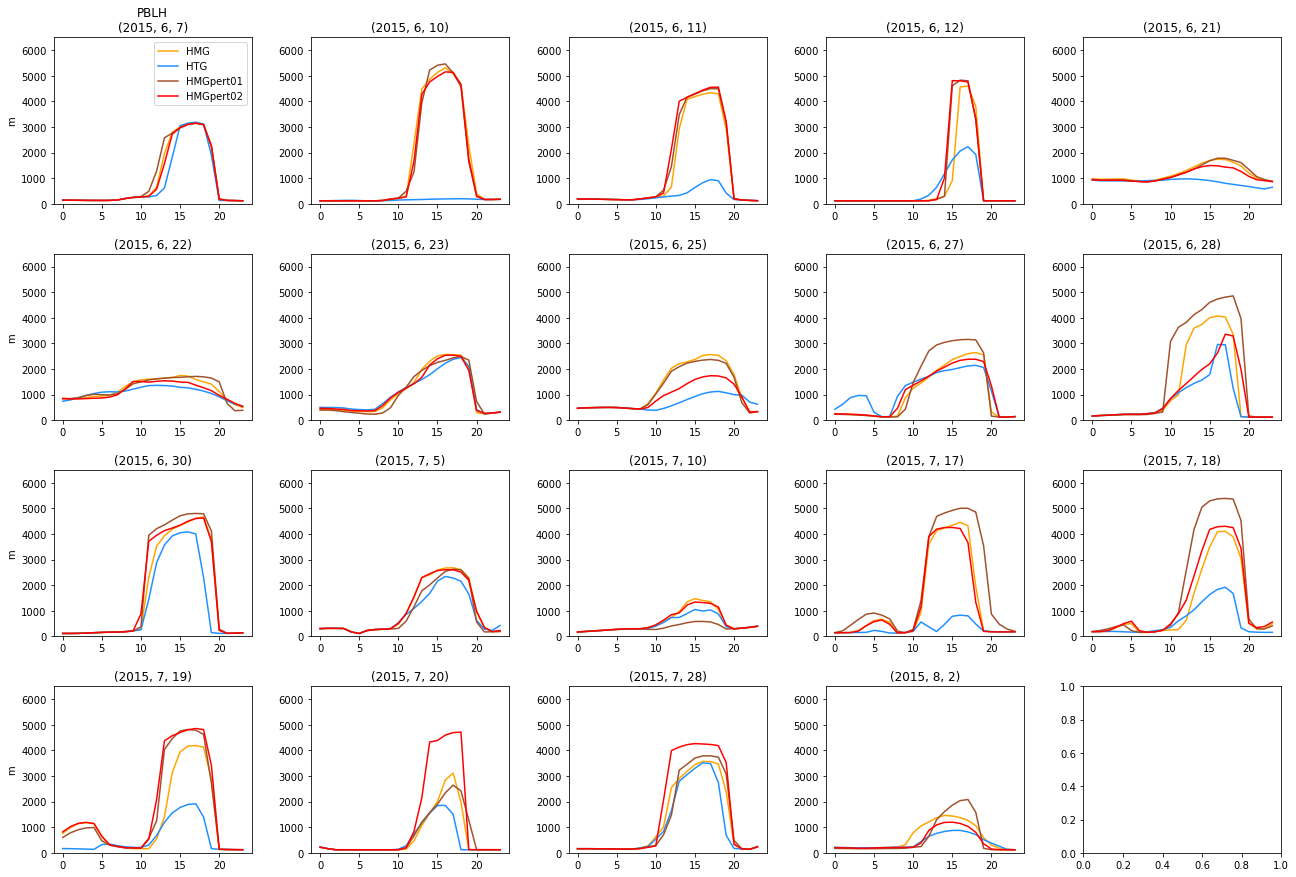

In [18]:
## Plot diurnal cycles for LWP-increase days 

# fig,axs = plt.subplots(3,5, figsize=(22,10))
fig,axs = plt.subplots(4,5, figsize=(22,15))

axs     = axs.ravel()
fig.subplots_adjust(hspace=0.3, wspace=0.3)

varSelPlot = 'PBLH'

for iDay in range(nNeg):
    #Select this time in array 
    iselDay = np.where((HMGcamDS_all_newDateHourly_lowPct['time.year']  == negDates[iDay][0]) & 
                       (HMGcamDS_all_newDateHourly_lowPct['time.month'] == negDates[iDay][1]) & 
                       (HMGcamDS_all_newDateHourly_lowPct['time.day']   == negDates[iDay][2]))[0]
    
    # Get hourly means for just this selected day
    selDayHMG      = HMGcamDS_all_newDateHourly_lowPct.isel(time=iselDay)
    selDayHTG      = HTGcamDS_all_newDateHourly_lowPct.isel(time=iselDay)
    selDayHMGpert1 = HMGcamDS_allPert1_newDateHourly_lowPct.isel(time=iselDay)
    selDayHMGpert2 = HMGcamDS_allPert2_newDateHourly_lowPct.isel(time=iselDay)
    
    axs[iDay].plot(np.arange(24), np.squeeze(selDayHMG[varSelPlot].values),     color='orange', label='HMG')
    axs[iDay].plot(np.arange(24), np.squeeze(selDayHTG[varSelPlot].values),     color='dodgerblue', label='HTG')
    axs[iDay].plot(np.arange(24), np.squeeze(selDayHMGpert1[varSelPlot].values), color='sienna', label='HMGpert01')
    axs[iDay].plot(np.arange(24), np.squeeze(selDayHMGpert2[varSelPlot].values), color='red', label='HMGpert02')
    
    if iDay==0:
        axs[iDay].set_title(varSelPlot+'\n'+str(negDates[iDay]))
        axs[iDay].legend()
    else:
        axs[iDay].set_title(str(negDates[iDay]))
        
    #set a consistent y limit
    axs[iDay].set_ylim([0,6500])
        
        
axs[0].set_ylabel(HMGcamDS_all[varSelPlot].units)
axs[5].set_ylabel(HMGcamDS_all[varSelPlot].units)
axs[10].set_ylabel(HMGcamDS_all[varSelPlot].units)
axs[15].set_ylabel(HMGcamDS_all[varSelPlot].units)

## Sanity check that "repeating" the HMG case works okay?

In [ ]:
# ## Read in files 

# # This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
# dataDirRepeat      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HMG_repeat/'
# caseName_HMGrepeat = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_useTheta_'

# yearStrings  = np.asarray(['2015'])
# dateEndFiles = np.asarray([ '-05-31-84585.nc',
#                             '-06-09-56985.nc',
#                             '-06-18-29385.nc',
#                             '-06-27-01785.nc',
#                             '-07-05-60585.nc',
#                             '-07-14-32985.nc',
#                             '-07-23-05385.nc',
#                             '-07-31-64185.nc',
#                             '-08-09-36585.nc',
#                             '-08-18-08985.nc',
#                             '-08-26-67785.nc' ])

# fileCount=0
# for iYr in range(len(yearStrings)): 

#     fileStart_atm_HMG   = dataDirRepeat+caseName_HMGrepeat+yearStrings[iYr]+'jja_repeat1.cam.h1.'+yearStrings[iYr]
    
#     for iFile in range(len(dateEndFiles)):
#         fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]

#         with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
#             HMG_camDS = cesm_correct_time(HMG_camDS)
#             HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()


#         # Discard the first two days if iFile == 0  
#         if iFile==0:
#             iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
#             timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

#             HMG_camDS      = HMG_camDS.isel(time=timeArr)


#         if fileCount==0:
#             HMGcamDSrepeat_all   = HMG_camDS       
            
#         else: 
#             HMGcamDSrepeat_all   = xr.concat([HMGcamDSrepeat_all,HMG_camDS], dim='time')

        
#         fileCount = fileCount+1
#         print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))


In [21]:
## Read in files 

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDirRepeat      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HMG_repeat/'
caseName_HMGrepeat = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_useTheta_'

yearStrings  = np.asarray(['2015'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc' ])
#                             '-07-05-60585.nc' ])
#                             '-07-14-32985.nc',
#                             '-07-23-05385.nc',
#                             '-07-31-64185.nc',
#                             '-08-09-36585.nc',
#                             '-08-18-08985.nc',
#                             '-08-26-67785.nc' ])

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG   = dataDirRepeat+caseName_HMGrepeat+yearStrings[iYr]+'jja_repeat2.cam.h1.'+yearStrings[iYr]
    
    for iFile in range(len(dateEndFiles)):
        fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]

        with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
            HMG_camDS = cesm_correct_time(HMG_camDS)
            HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()


        # Discard the first two days if iFile == 0  
        if iFile==0:
            iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
            timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

            HMG_camDS      = HMG_camDS.isel(time=timeArr)


        if fileCount==0:
            HMGcamDSrepeat2_all   = HMG_camDS       
            
        else: 
            HMGcamDSrepeat2_all   = xr.concat([HMGcamDSrepeat2_all,HMG_camDS], dim='time')

        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))


FileNotFoundError: [Errno 2] No such file or directory: b'/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HMG_repeat/FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_useTheta_2015jja_repeat2.cam.h1.2015-05-31-84585.nc'

In [5]:
# ## Get same end time as well... 
# # iTimeEnd_v2 = np.where(HMGv2camDS_all.time.values == HMGcamDS_all.time.values[-1])[0]
# # HMGv2camDS_all = HMGv2camDS_all.isel(time=np.arange(0, int(iTimeEnd_v2)+1))


# iTimeEnd_v2       = np.where(HMGcamDS_all.time.values == HMGcamDSrepeat2_all.time.values[-1])[0]
# HMGcamDScheck_all = HMGcamDS_all.isel(time=np.arange(0, int(iTimeEnd_v2)+1))



NameError: name 'HMGcamDSrepeat2_all' is not defined

Text(0.5, 1.0, 'THLP2_CLUBB')

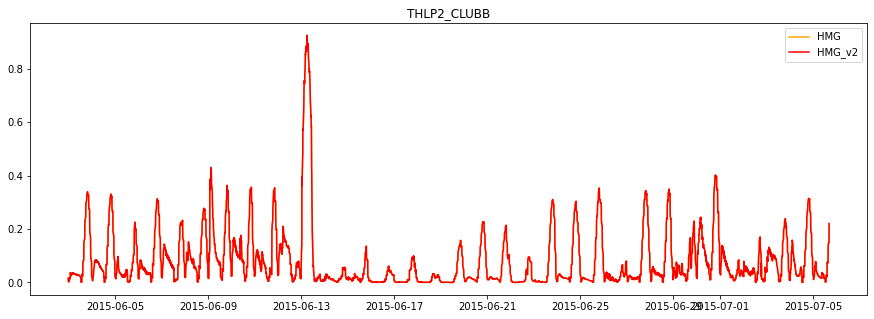

In [17]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'THLP2_CLUBB'
levSel     = -1


axs.plot(HMGcamDScheck_all.time.values,    np.squeeze(HMGcamDScheck_all[varSelPlot].values[:,levSel]), color='orange', label='HMG')
axs.plot(HMGcamDSrepeat2_all.time.values,  np.squeeze(HMGcamDSrepeat2_all[varSelPlot].values[:,levSel]), color='red', label='HMG_v2')
# axs.plot(HMGcamDSrepeat_all.time.values,  np.squeeze(HMGcamDSrepeat_all[varSelPlot].values[:,levSel]), color='olive', label='HMGrepeat')

# axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
axs.legend()
axs.set_title(varSelPlot)

# axs.set_ylim([0,0.5])


Text(0.5, 1.0, 'PBLH')

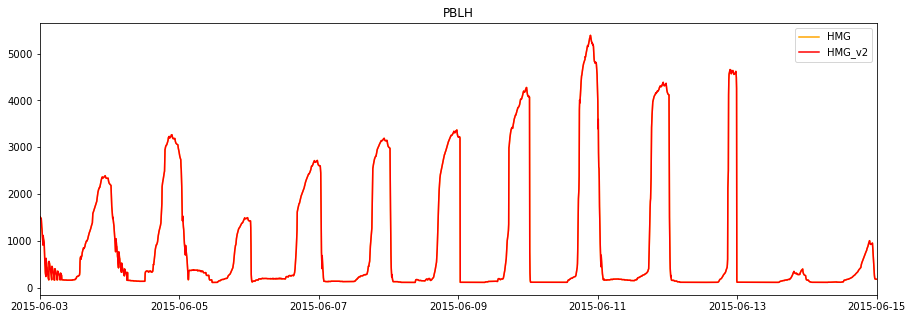

In [18]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

# varSelPlot = 'T'
varSelPlot = 'PBLH'
levSel     = None


axs.plot(HMGcamDScheck_all.time.values,    np.squeeze(HMGcamDScheck_all[varSelPlot].values[:,levSel]), color='orange', label='HMG')
axs.plot(HMGcamDSrepeat2_all.time.values,  np.squeeze(HMGcamDSrepeat2_all[varSelPlot].values[:,levSel]), color='red', label='HMG_v2')
# axs.plot(HMGcamDSrepeat_all.time.values,  np.squeeze(HMGcamDSrepeat_all[varSelPlot].values[:,levSel]), color='olive', label='HMGrepeat')

axs.set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,15)])
axs.legend()
axs.set_title(varSelPlot)

# axs.set_ylim([0,0.5])
